# VelocityHack
Swung London Hackathon
1st-2nd June 2019

In [1]:
import lasio
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### Load LAS Data

In [2]:
gn3 = lasio.read('data/GN3.las')

Header section Parameter regexp=~P was not found.


In [3]:
gn3.header

{'Version': [HeaderItem(mnemonic=VERS, unit=, value=2.0, descr=CWLS LOG ASCII STANDARD -V...),
  HeaderItem(mnemonic=WRAP, unit=, value=NO, descr=ONE LINE PER DEPTH STEP)],
 'Well': [HeaderItem(mnemonic=STRT, unit=m, value=8.9916, descr=START DEPTH),
  HeaderItem(mnemonic=STEP, unit=m, value=0.1524, descr=STEP DEPTH),
  HeaderItem(mnemonic=STOP, unit=m, value=2706.1668, descr=STOP DEPTH),
  HeaderItem(mnemonic=NULL, unit=, value=-999.25, descr=NULL VALUE),
  HeaderItem(mnemonic=COMP, unit=, value=, descr=COMPANY),
  HeaderItem(mnemonic=WELL, unit=, value=, descr=WELL),
  HeaderItem(mnemonic=LOC, unit=, value=, descr=LOCATION - AREA),
  HeaderItem(mnemonic=FLD, unit=, value=, descr=FIELD),
  HeaderItem(mnemonic=CTRY, unit=, value=, descr=COUNTRY),
  HeaderItem(mnemonic=DATE, unit=, value=, descr=WELL DATE),
  HeaderItem(mnemonic=XWELL, unit=m, value=, descr=X POS),
  HeaderItem(mnemonic=YWELL, unit=m, value=, descr=Y POS),
  HeaderItem(mnemonic=EDF, unit=, value=6.1, descr=DERRICK FLOOR

In [4]:
gn3['VP']

array([nan, nan, nan, ..., nan, nan, nan])

#### Plot Velocity Log

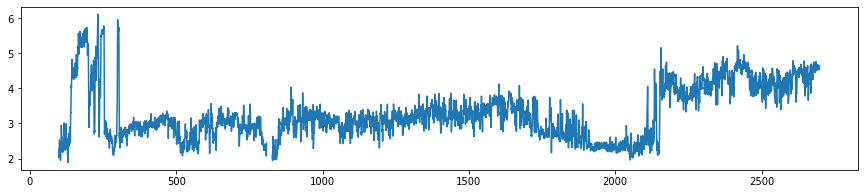

In [5]:
plt.figure(figsize=(15, 3))
plt.plot(gn3['DEPT'], gn3['VP'])
plt.show()

#### Load curves as Pandas dataframe

In [6]:
gn3.df().head()

,DTCO,VP,DTSM,VS,RHOB,CGR,VWCL,PHIT
DEPT,,,,,,,,
8.9916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.1440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.2964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.4488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.6012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


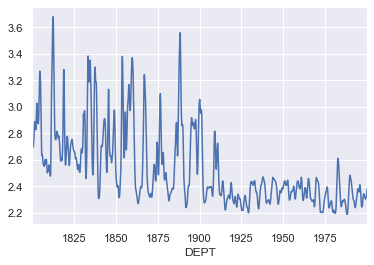

In [14]:
gn3.df().loc[1800:2000].VP.plot()

In [8]:
depth = gn3.df().loc[1100:1500].index.values.reshape(-1,1)
vp =  gn3.df().loc[1100:1500].VP.values.reshape(-1,1)
vp = vp*1000

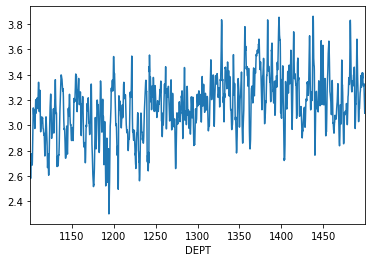

In [9]:
gn3.df().loc[1100:1500].VP.plot()

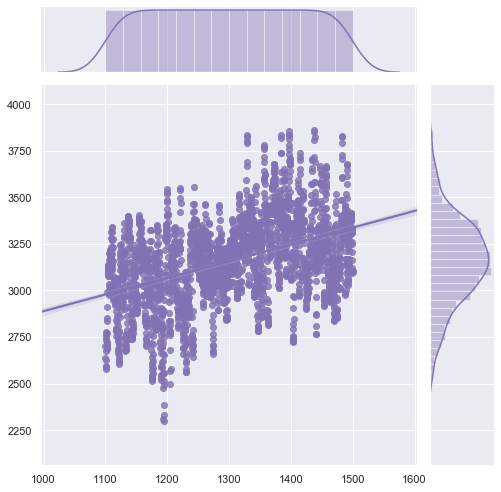

In [10]:
import seaborn as sns
sns.set(style="darkgrid")

g = sns.jointplot(depth, vp, kind="reg", color="m", height=7)

# Simulating pairs of K and V0 

In [11]:
import numpy as np
import matplotlib.pyplot as plt


In [12]:
def linear_velocity(depth, vel, k_range=(-3, 3), v0_range=(1500,5000), nr_samples = 10000):
    k = np.random.uniform(*k_range, nr_samples)
    v0 = np.random.uniform(*v0_range, nr_samples)
    pred_vel = depth*k+v0
    
    # calculate the errors
    mse = np.mean((vel-pred_vel)**2,axis=0)
    rmse = np.sqrt(mse)
    
    return k, v0, pred_vel, rmse

def plot_rmse_ellipse(ax, k, v0, rmse, min_error=300):
    
    idx = np.where(rmse < min_error)
    idx_min = rmse.argmin()
    
    
    sc= ax.scatter(k[idx], v0[idx], c=rmse[idx], s=10)
    ax.scatter(k[idx_min], v0[idx_min], c='yellow', s=100, marker='X')
    #plt.colorbar()
    return sc

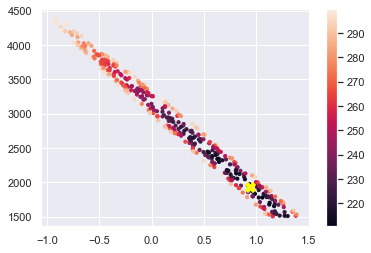

In [13]:
k, v0, pred_vel, rmse = linear_velocity(depth, vp)

fig, ax = plt.subplots(1,1)
sc = plot_rmse_ellipse(ax, k, v0, rmse)
plt.colorbar(sc)

# Todo

* Bayesian modelling, sampling - Uncertainty quantification
* Clustering picking of formations using Gaussian Mixture Models etc..
* Run the lin_velocity function on multiple wells and formations find low error ranges for V0 and K
* interactive visualisation V0, K for a log

## Clustering 

In [153]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

In [125]:
#df = gn3.df()[['VP','VS','RHOB','CGR','VWCL','PHIT']].dropna()
df = gn3.df()[['VP','VS','RHOB']].dropna()

In [126]:
df = df.rolling(100, min_periods=1).median()

In [127]:
df.count()

VP      16780
VS      16780
RHOB    16780
dtype: int64

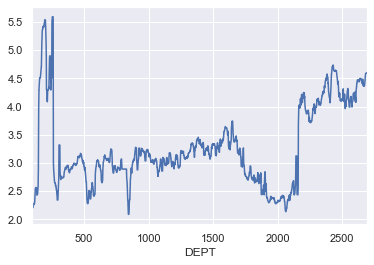

In [128]:
df['VP'].plot()

In [129]:
X = df.reset_index().values
#X = df.values

In [130]:
from sklearn.preprocessing import MinMaxScaler

In [131]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [118]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_scaled)

In [119]:
kmeans.labels_

array([0, 0, 0, ..., 1, 1, 1])

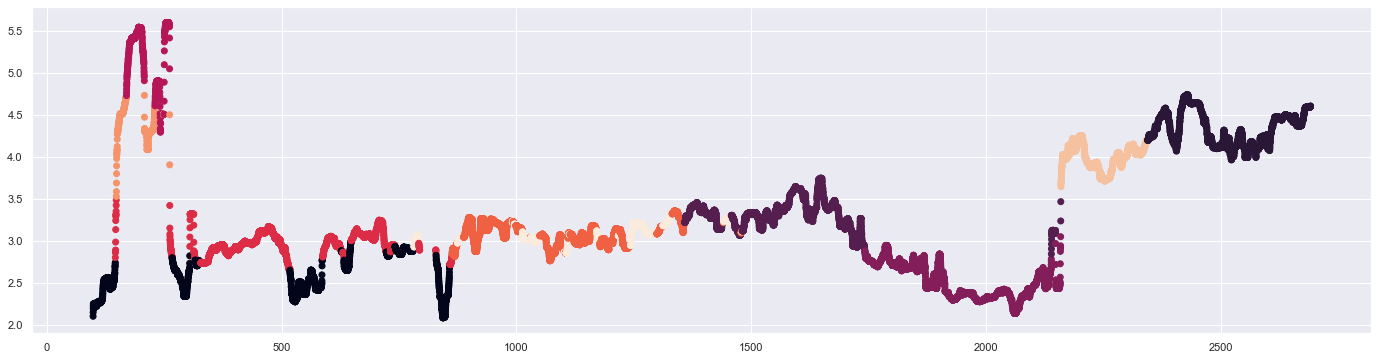

In [120]:
fig, ax = plt.subplots(1,1, figsize=(24,6))
plt.scatter(df.index, df['VP'], c=kmeans.labels_)

In [148]:
dbscan = DBSCAN(eps=0.05).fit(X_scaled)

In [149]:
dbscan.labels_

array([-1, -1,  0, ..., 11, 11, 11], dtype=int64)

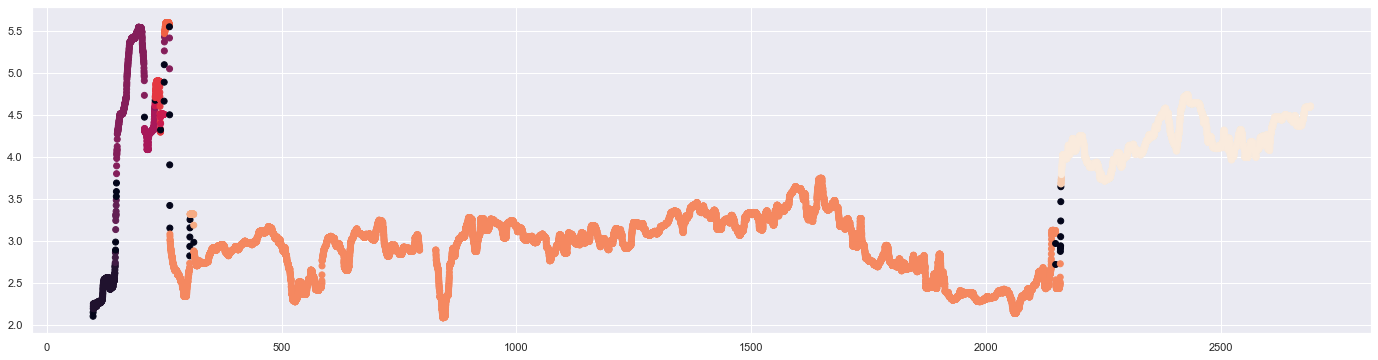

In [150]:
fig, ax = plt.subplots(1,1, figsize=(24,6))
plt.scatter(df.index, df['VP'], c=dbscan.labels_)

In [158]:
gmm = GaussianMixture(n_components=5).fit(X_scaled)

In [159]:
gmm.predict(X)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)